In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from skimage import io, color
from tqdm import tqdm
import random
from numpy import linalg as LA
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
image_folders = glob("./visuelle/images/*/", recursive = True)

In [3]:
#define a help function to return the names of all the images in the folder
def only_files(dir_path):
    return [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

In [4]:
from skimage.transform import rescale, resize

def get_image2(image_path: str, target_ar = 0.62, target_w = 200):
    """
    :param image_path: string, path of the image
    :param resize: boolean, if True the image is resized. Default: True
    :param w: integer, specify the width of the resized image
    :return: numpy array of the greyscale version of the image
    """
    target_h = int(target_w*target_ar)

    try:
        image = imread(image_path) #it's a numpy array
        h, w, channels = image.shape
        ar = h/w

        if ar > target_ar:
            w = int((float(target_h)/float(ar)))
            h = target_h
            dw = target_w - w
            image = resize(image, (h,w), anti_aliasing=True)
            w_div2 = int(dw/2)
            new_image = np.zeros([h, target_w, 4])
            for i in range(channels):
                im = image[:,:,i]
                zeros_ = np.zeros(shape=[h, w_div2])
                im = np.concatenate((zeros_, im), axis=1)
                zeros_ = np.zeros(shape=[h, dw - w_div2])
                im = np.concatenate((im, zeros_), axis=1)
                new_image[:,:,i] = im
            return new_image

        else:
            w = target_w
            h = int(w/ar)
            dh = h - target_h
            h_div2 = int(dh/2)
            image = resize(image, (h, w), anti_aliasing=True)
            new_image = np.zeros([target_h, w, 4])
            for i in range(channels):
                im = image[:,:,i]
                im = im[h_div2:-(dh-h_div2), :]
                new_image[:,:,i] = im
            return new_image

    except:
        #AI19/04442.png corrupted
        #AI18/02971.png corrupted
        print("problem!")
        return np.zeros(shape=[target_h, target_w, 4])

In [5]:
def to_csv(array: np.array, name: str):
    df= pd.DataFrame(array)
    df.to_csv(name, index=False)

def from_csv(name: str):
    df = pd.read_csv(name)
    array = df.to_numpy()
    return array

In [6]:
def extract_images(paths:list, target_w: int, target_h: int, target_ar: int):
    A = np.zeros([len(paths), target_w * target_h * 4])
    counter = 0

    for image_path in tqdm(paths):
        im = get_image2(image_path=image_path, target_ar=target_ar, target_w=target_w)
        if im is not None:
            A[counter, :] = im.reshape(1, -1)
            counter += 1
        else:
            continue

    return A.T

In [7]:
import scipy.stats
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM

class GM1D():

    def __init__(self, data: np.array, autotune=True, k=2, maximum_modes=2, max_iter = 1000, verbose=False):
        self.data = data.reshape(-1,1)
        self.maximum_modes = maximum_modes
        self.max_iter = max_iter
        self.verbose = verbose
        if autotune:
            self.k = self.get_number_modes()
        else:
            self.k = k
        self.gmm = GMM(n_components=self.k, random_state=0).fit(self.data)
        self.mean = self.gmm.means_
        self.covariances = self.gmm.covariances_
        self.weights = self.gmm.weights_


    def get_number_modes(self):
        # first of all, let's confirm the optimal number of components
        bics = []
        min_bic = 0
        counter=1
        for i in range(self.maximum_modes): # test the AIC/BIC metric between 1 and 10 components
            gmm = GMM(n_components = counter, max_iter=self.max_iter, random_state=0, covariance_type = 'full')
            labels = gmm.fit(self.data).predict(self.data)
            bic = gmm.bic(self.data)
            bics.append(bic)
            if bic < min_bic or min_bic == 0:
                min_bic = bic
                opt_bic = counter
            counter = counter + 1

        if self.verbose:
            # plot the evolution of BIC/AIC with the number of components
            fig = plt.figure(figsize=(10, 4))
            ax = fig.add_subplot(1,2,1)
            # Plot 1
            plt.plot(np.arange(1,self.maximum_modes+1), bics, 'o-', lw=3, c='black', label='BIC')
            plt.legend(frameon=False, fontsize=1)
            plt.xlabel('Number of components', fontsize=20)
            plt.ylabel('Information criterion', fontsize=20)
            plt.xticks(np.arange(0,11,2))
            plt.title('Opt. components = '+str(opt_bic), fontsize=20)

        return opt_bic

    def pdf(self, x):
        tmp = 0
        for index in range(self.k):
            tmp += norm.pdf(x, self.mean[index,0], np.sqrt(self.covariances[index,0]))*self.weights[index]
        return np.log(tmp[0])

    def plot_pdf_modeled(self, n_bins=25):
        x_data = np.linspace(np.min(self.data),np.max(self.data), n_bins+1)
        data_ = [np.exp(self.pdf(d)) for d in x_data]

        plt.hist(self.data,density=True,bins=n_bins)
        plt.plot(x_data, np.array(data_))


class BayesianClassifier():
    def __init__(self, data: np.ndarray, labels: list, normalize = False, verbose=False):
        if normalize:
            scaler = StandardScaler()
            self.data = scaler.fit_transform(data)
        else:
            self.data = data
        self.labels = np.array(labels)
        self.n_classes = len(set(labels))
        self.unique_labels = {code: label for code, label in zip(range(self.n_classes), set(labels))}
        self.n_features = len(data[0])
        self.prior = np.zeros(self.n_classes)
        self.means = np.zeros((self.n_classes, self.n_features))
        self.std_ = np.zeros((self.n_classes, self.n_features))
        #self.likelihood = {class_: [] for class_ in self.unique_labels}
        self.mixture_model = [GM1D(data=self.data[:,i], verbose=verbose) for i in range(self.n_features)]
        self.train()

    def train(self):
        for i in range(self.n_classes):
            self.prior[i] = np.log(np.sum(self.labels == self.unique_labels[i]) / self.labels.shape[0])
            for j in range(self.n_features):
                # I create the likelihood model for each feature
                self.means[i][j] = np.mean(self.data[self.labels == self.unique_labels[i], j])
                self.std_[i][j] = np.std(self.data[self.labels == self.unique_labels[i], j])
                #each entry is a pdf object with the mean and std of the feature
                #self.likelihood[class_].append(lambda x: np.log(scipy.stats.norm(self.means[i][j], self.std_[i][j]).pdf(x)))

    def predict(self, data:np.ndarray, weights=None, y_true = None, use_mixture_model = True):
        predictions = []
        prob_dataframe = pd.DataFrame(columns=[code for code in self.unique_labels.keys()])
        for i in tqdm(range(data.shape[0])):
            observation = data[i]
            if use_mixture_model:
                prediction, probabilities = self.predict_single(data=observation, use_mixture_model=True, weights=weights)
            else:
                prediction, probabilities = self.predict_single(data=observation)
            prob_dataframe = pd.concat([prob_dataframe, pd.DataFrame(data=probabilities.reshape(1,-1))], ignore_index=True)
            predictions.append(prediction)
        prob_dataframe = prob_dataframe.rename(columns=self.unique_labels)
        if y_true:
            score = accuracy_score(y_true=y_true,y_pred=predictions)
            print("The score of the classifier is: {}".format(score))
        return (predictions, prob_dataframe)

    def predict_single(self, data:np.ndarray, use_mixture_model=True, weights=None):
        probabilities = np.zeros(self.n_classes)
        for i in range(self.n_classes):
            #add the prior at the estimate
            probabilities[i] = self.prior[i]
            for j in range(self.n_features):
                #calcluate the likehood for this class and this feature
                if use_mixture_model:
                    calculations = self.mixture_model[j].pdf(data[j])
                else:
                    calculations = np.log(
                        scipy.stats.norm(self.means[i][j], self.std_[i][j]).pdf(data[j])
                    )
                if weights is not None:
                    #rescale the calculations: if a feature has an higher eigenvalue the associated
                    #contribute will be smaller and, in global, it will have an higher impact in the
                    #classification.
                    calculations = calculations/weights[j]

                probabilities[i] += calculations
        index = np.argmax(probabilities)
        return (self.unique_labels[index], probabilities)

In [8]:
def start_over_dr(data, test_size=0.8):
    y = [(cat, color) for cat, color in zip(data.category.to_list(), data.color.to_list())]
    df_drA_total = pd.read_csv("dr_images.csv")
    drA_total = df_drA_total.to_numpy()

    del df_drA_total

    drA_train, drA_test, y_train, y_test = train_test_split(drA_total, y, test_size=test_size, random_state=58)

    y_test_color = [c for _, c in y_test]
    y_train_color = [c for _, c in y_train]

    y_test = [category for category, _ in y_test]
    y_train = [category for category, _ in y_train]

    return drA_train, drA_test, y_test_color, y_train_color, y_test, y_train


In [9]:
from numpy.linalg import eig

def eigen_training(A):
    n, m = A.shape
    L = np.matmul(A.T, A)

    eigenValues, eigenVectors = eig(L)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    #U are the igenvectors in the original referiment system
    U = np.matmul(A, eigenVectors)

    for i in range(m):
        #normalize
        U[i,:] = np.linalg.norm(U[i,:])

    return (eigenValues, U)

## Load the data

In [10]:
data = pd.read_csv("./visuelle/test.csv")
data_test = data
data_train = pd.read_csv("./visuelle/train.csv")
data = pd.concat([data_test, data_train])
print(len(data))
data["image_path"] = "./visuelle/images/"+ data.image_path.astype(str)
data_test["image_path"] = "./visuelle/images/"+ data_test.image_path.astype(str)
data_train["image_path"] = "./visuelle/images/"+ data_train.image_path.astype(str)

5575


In [11]:
data

,0,1,2,3,4,5,6,7,8,9,...,category,release_date,day,week,month,year,image_path,color,fabric,extra
0,0.032864,0.062911,0.054460,0.056338,0.042254,0.033803,0.037559,0.029108,0.016901,0.012207,...,short sleeves,2019-04-17,0.333333,0.307692,0.333333,1.0,./visuelle/images/PE19/05081.png,grey,georgette,hem
1,0.046948,0.060094,0.083568,0.117371,0.079812,0.089202,0.078873,0.061033,0.023474,0.015962,...,culottes,2019-04-17,0.333333,0.307692,0.333333,1.0,./visuelle/images/PE19/05082.png,red,bengaline,strapless
2,0.043192,0.086385,0.079812,0.080751,0.061972,0.062911,0.054460,0.045070,0.021596,0.015962,...,kimono dress,2019-04-17,0.333333,0.307692,0.333333,1.0,./visuelle/images/PE19/05083.png,white,frise,hem
3,0.060094,0.090141,0.076995,0.060094,0.041315,0.024413,0.018779,0.006573,0.002817,0.001878,...,long sleeve,2019-04-17,0.333333,0.307692,0.333333,1.0,./visuelle/images/PE19/05084.png,grey,scuba crepe,hem
4,0.062911,0.108920,0.105164,0.116432,0.066667,0.059155,0.056338,0.076056,0.061033,0.053521,...,doll dress,2019-04-17,0.333333,0.307692,0.333333,1.0,./visuelle/images/PE19/05085.png,grey,georgette,hem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5073,0.016901,0.018779,0.020657,0.015023,0.010329,0.020657,0.023474,0.015962,0.015962,0.011268,...,sheath dress,2019-10-23,0.333333,0.826923,0.833333,1.0,./visuelle/images/AI19/05076.png,black,scuba crepe,racerback
5074,0.026291,0.039437,0.044131,0.030986,0.032864,0.058216,0.027230,0.044131,0.046009,0.024413,...,kimono dress,2019-10-23,0.333333,0.826923,0.833333,1.0,./visuelle/images/AI19/05077.png,black,nice,zipper
5075,0.000939,0.001878,0.011268,0.014085,0.010329,0.015023,0.011268,0.015962,0.003756,0.017840,...,medium coat,2019-10-24,0.500000,0.826923,0.833333,1.0,./visuelle/images/AI19/05078.png,black,foam rubber,sleeve
5076,0.001878,0.059155,0.045070,0.050704,0.063850,0.121127,0.066667,0.098592,0.148357,0.101408,...,kimono dress,2019-10-25,0.666667,0.826923,0.833333,1.0,./visuelle/images/AI19/05079.png,green,acrylic,hem


In [12]:
#choices of the feature size

target_ar = 0.62
target_w = 175
target_h = int(target_w*target_ar)

print("The number of feature, for each image, is {}".format(
    target_w*target_h*4
))

The number of feature, for each image, is 75600


In [13]:
# first choice: load the dat directly from the dataset
X = data.image_path.to_list()

A_total = extract_images(paths=X, target_w=target_w, target_h=target_h, target_ar=target_ar)

100%|██████████| 5575/5575 [04:52<00:00, 19.06it/s]


In [17]:
### second choice: load the data from the .csv (faster!!)

#df_A_total = pd.DataFrame(A_total)
#df_A_total.to_csv("raw_images.csv", index=False)

df_A_total = pd.read_csv("raw_images.csv")
A_total = df_A_total.to_numpy()

del df_A_total

In [16]:
test_size = 0.1

X = data.image_path.to_list()
y = [(cat, color) for cat, color in zip(data.category.to_list(), data.color.to_list())]

A_train, A_test, y_train, y_test = train_test_split(A_total.T, y, test_size=test_size, random_state=58)

y_test_color = [c for _, c in y_test]
y_train_color = [c for _, c in y_train]

y_test = [category for category, _ in y_test]
y_train = [category for category, _ in y_train]

print("I will use {} images to train the model and {} images to validate it".format(
    len(A_train), len(A_test)
))

I will use 5017 images to train the model and 558 images to validate it


### Dataset analysis

In [126]:
#help function to convert images in array

tmp = []
for image_path in tqdm(data.image_path.to_list()):
    try:
        w, h, _ = get_image2(image_path, target_w=target_w).size
        tmp.append((image_path,w,h))
    except:
        continue

  7%|▋         | 417/5575 [00:25<04:50, 17.76it/s]

problem!


100%|██████████| 5575/5575 [04:22<00:00, 21.24it/s]


In [128]:
tmp


[]

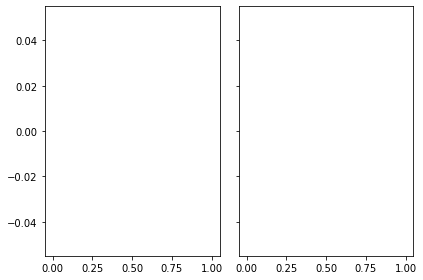

In [127]:
heights = [h for _,h,_ in tmp]
widths = [w for _,_,w in tmp]

n_bins = 50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
(n_h, bins_h, patches_h) = axs[0].hist(heights, bins=n_bins)
(n_w, bins_w, patches_w) = axs[1].hist(widths, bins=n_bins)
plt.show()

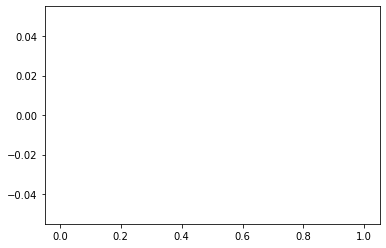

In [124]:
aspect_ratio = [h/w for _,h,w in tmp]

# create the histogram
(n, bins, patches) = plt.hist(aspect_ratio, bins=n_bins)

plt.show()

## PCA

In [15]:
#first choice: import the already PCAd datasets

df_drA_total = pd.read_csv("dr_images.csv")
drA_total = df_drA_total.to_numpy()

drA_train, drA_test, y_train, y_test = train_test_split(drA_total, y, test_size=test_size, random_state=58)

y_test_color = [c for _, c in y_test]
y_train_color = [c for _, c in y_train]

y_test = [category for category, _ in y_test]
y_train = [category for category, _ in y_train]


In [ ]:
#second choice: process the total dataset from scratch

from sklearn.preprocessing import StandardScaler

n_components = 500
pca = PCA(n_components=n_components)

scaler = StandardScaler()
#A_train_tilde = scaler.fit_transform(A_train)
#A_test_tilde = scaler.fit_transform(A_test)
A_train_tilde = A_train - A_train.mean(axis=0).reshape(1,-1)
A_test_tilde = A_test - A_test.mean(axis=0).reshape(1,-1)

drA_train = pca.fit_transform(A_train_tilde)
drA_test = pca.fit_transform(A_test_tilde)

eigenvalues = pca.explained_variance_ratio_
eigenvectors = pca.components_


In [ ]:
to_csv(drA_train, "dr_Atrain_huge.csv")
to_csv(drA_test, "dr_Atest_huge.csv")

In [ ]:
information = pca.explained_variance_ratio_.cumsum()[-1]
print("With {} eigenvectors I model {:.2f}% of information".format(n_components, information*100))

In [ ]:
plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)
plt.show()

In [61]:
n_features = np.where(pca.explained_variance_ratio_.cumsum()>0.8)[0][0]
print("The number of features to have 80% of information is: {}".format(n_features))

NameError: name 'pca' is not defined

In [3]:
values, vectors = eigen_training(A_train)

NameError: name 'eigen_training' is not defined

In [ ]:
plt.figure(figsize=(18, 7))

for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(vectors[:,i].reshape([-1, target_w,4]))
plt.show()

In [ ]:
drA_train = drA_train[:,:150]
drA_test = drA_test[:,:150]

## Bayes naive classifier

Firstly, let's try a single mode naive Bayes classifier

In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

gnb = GaussianNB()
y_pred = gnb.fit(drA_train, y_train).predict(drA_test)

In [60]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

         capris       0.00      0.00      0.00        15
       culottes       0.42      0.80      0.55       557
     doll dress       0.35      0.17      0.23       171
    drop sleeve       0.00      0.00      0.00        65
   gitana skirt       0.00      0.00      0.00        17
   kimono dress       0.18      0.47      0.26       111
  long cardigan       0.00      0.00      0.00         8
      long coat       0.09      0.12      0.11        81
     long dress       0.00      0.00      0.00       112
    long duster       0.00      0.00      0.00        10
    long sleeve       0.36      0.30      0.33       728
           maxi       0.00      0.00      0.00        21
medium cardigan       0.00      0.00      0.00        35
    medium coat       0.09      0.05      0.06        60
      miniskirt       0.00      0.00      0.00        30
      patterned       0.19      0.12      0.15       142
        printed       0.00    

/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Let's use a custom classifier that use a multimodal gaussian mixture. The classifier autotunes (single or bi-modal) based on the results obtained from the optimizer

In [64]:
classifier = BayesianClassifier(data=drA_train[:,:10], labels=y_train) #try the classificator with only the first ten components

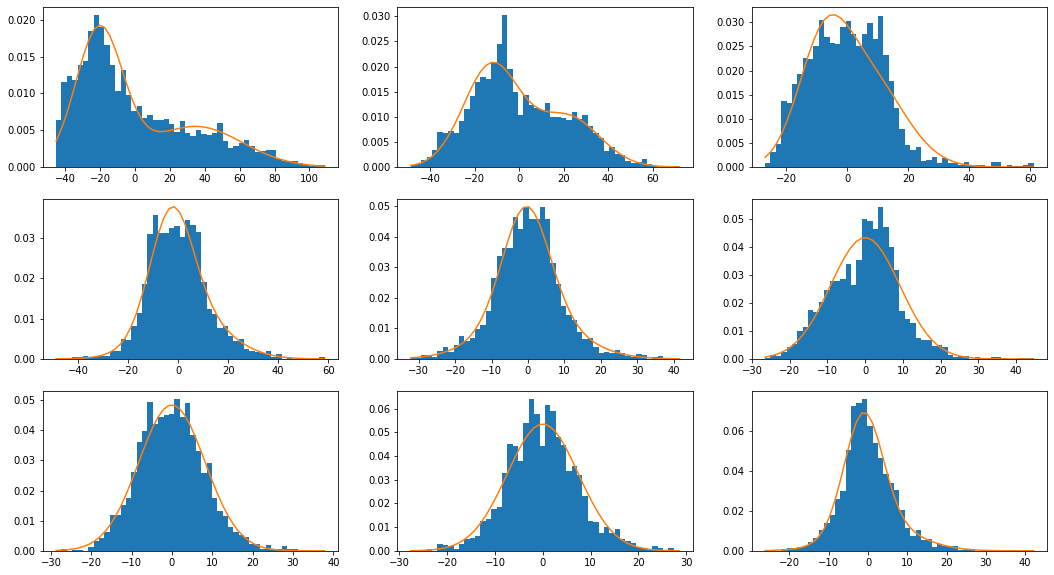

In [65]:
plt.figure(figsize=(18, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    classifier.mixture_model[i].plot_pdf_modeled(n_bins=50)
plt.show()

In [ ]:
predictions, prob_dataframe = classifier.predict(data=drA_test[:,:10],y_true=y_test)

In [67]:
classifier_color = BayesianClassifier(data=drA_train[:,:10], labels=y_train_color) #try the classificator with only the first ten components
predictions_color, prob_color_dataframe = classifier_color.predict(data=drA_test[:,:10],y_true=y_test_color)

100%|██████████| 3345/3345 [00:20<00:00, 161.53it/s]

The score of the classifier is: 0.20418535127055307


## SVC

In [21]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

svc = SVC(kernel='rbf', class_weight='balanced')

In [22]:
from sklearn.model_selection import GridSearchCV

def fit_SVC_model(model, c_params, gamma_params, X_train, y_train):
    param_grid = dict(gamma=gamma_params, C=c_params)
    grid = GridSearchCV(model, param_grid)
    %time grid.fit(X_train, y_train)

    print(
        "The best parameters are %s with a score of %0.2f"
        % (grid.best_params_, grid.best_score_)
    )

    return grid

In [23]:
c_params = [20 ,50, 100]
#gamma_params = [0.0001, 0.0005, 0.001, 0.005]
gamma_params = [0.0001, 0.0005, 0.001, 0.01, 0.1, 1]
#high gamma means more curvature and, low gamma then less curvature

In [24]:
len(y_train)

2787

In [28]:
grid = fit_SVC_model(svc, c_params, gamma_params, drA_train[:,:70], y_train)

CPU times: user 1min 1s, sys: 491 ms, total: 1min 2s
Wall time: 1min 6s
The best parameters are {'C': 100, 'gamma': 0.0005} with a score of 0.61


In [29]:
model = grid.best_estimator_
yfit = model.predict(drA_test[:,:70])


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

                 precision    recall  f1-score   support

         capris       0.00      0.00      0.00        13
       culottes       0.74      0.89      0.81       466
     doll dress       0.34      0.41      0.37       147
    drop sleeve       0.06      0.02      0.03        59
   gitana skirt       0.00      0.00      0.00        14
   kimono dress       0.11      0.12      0.11        86
  long cardigan       0.00      0.00      0.00         6
      long coat       0.10      0.05      0.06        64
     long dress       0.00      0.00      0.00        91
    long duster       0.00      0.00      0.00         6
    long sleeve       0.45      0.70      0.55       606
           maxi       0.00      0.00      0.00        16
medium cardigan       0.00      0.00      0.00        29
    medium coat       0.00      0.00      0.00        50
      miniskirt       0.67      0.08      0.15        24
      patterned       0.21      0.16      0.18       124
        printed       0.86    

/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [31]:
from sklearn.metrics import confusion_matrix

labels = list(set(y_test))
cm = confusion_matrix(y_test, yfit, labels=labels)

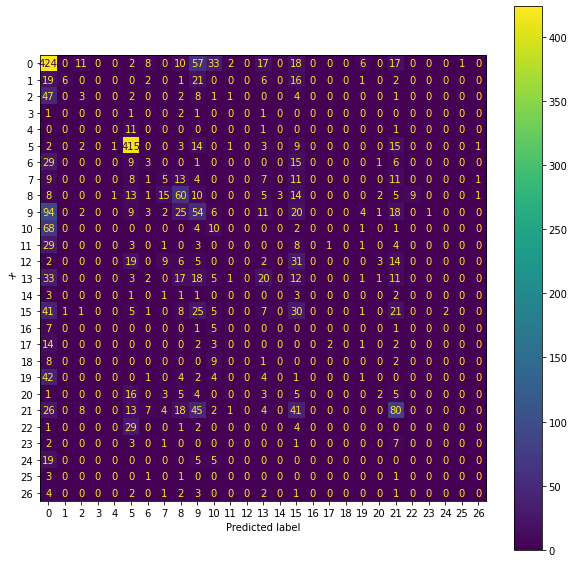

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, yfit, labels=labels)
cmp = ConfusionMatrixDisplay(cm, display_labels=range(27))
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(axis='x', labelrotation = 45)
cmp.plot(ax=ax)
plt.ylabel("x", rotation=45)

plt.show()


### Bag of image words

In this example image I found 257 descriptors. Each descriptor is a patch, a representation of “visual word” of the image (composed on 128 numbers).

The kmeans method clusters descriptors_float, which is a matrix that represents the entire dataset of images, into k centroids that represent the image. The kmeans method returns a tuple: voc, which is the array that contains the 27 “centroids” of the clustered 128 dimensional space, and variance (not used in this analysis)

In [63]:
from scipy.cluster.vq import kmeans,vq
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

class BagOfWords():

    def __init__(self, A_, y_train, target_w=150, channels=4, k = 1000, c_params = [1, 10, 100], gamma_params = [0.01, 0.1, 1, 10]):
        self.A_ = A_
        self.y_train = y_train
        self.target_w = target_w
        self.channels = channels
        self.n_images_paths, self.n_features = self.A_.shape
        self.k = k
        self.sift = cv2.SIFT_create()
        self.des_list, self.kp_list, self.descriptors_float = self.get_descriptors(A_=self.A_)
        print("creating centroids")
        self.voc, self.variance = kmeans(self.descriptors_float, self.k, 20)
        self.features = self.vector_quantization(self.des_list, self.n_images_paths, self.k, self.voc)
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)
        self.c_params = c_params
        self.gamma_params = gamma_params
        self.model = self.train_model()


    def get_descriptors(self, A_):
        des_list = []
        kp_list = []
        images, features = A_.shape
        for i in tqdm(range(images)):
            im = A_[i,:]
            im = im.reshape([-1, self.target_w, self.channels])
            im = cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            kp = self.sift.detect(im,None)
            keypoints,descriptor= self.sift.compute(im, kp)
            des_list.append(descriptor)
            kp_list.append(keypoints)

        first_ = True
        for descriptor in des_list:
            if descriptor is not None:
                if first_:
                    descriptors = descriptor
                    first_ = False
                else:
                    descriptors = np.concatenate((descriptors, descriptor))
            else:
                continue
        descriptors_float = descriptors.astype(float)
        return des_list, kp_list, descriptors_float

    def draw_keypoints(self, index=0, color=(255, 255, 255)):
        keypoints = self.kp_list[index]
        im = self.A_[index,:]
        for kp in tqdm(keypoints):
            x, y = kp.pt
            plt.imshow(cv2.circle(im, (int(x), int(y)), 2, color))

    def vector_quantization(self, des_list, n_images_paths, k, voc):
        features = np.zeros((n_images_paths, k), "float32")
        for i in tqdm(range(n_images_paths)):
            try:
                # Use the codebook to assign each observation to a cluster via vector quantization
                # labels, distance = vq(dataset, codebook)
                image_words, distance = vq(des_list[i], voc)
                for w in image_words:
                    features[i][w] += 1
            except:
                # if the image has no image_words, continue (the row will be all zeros)
                continue
        return features

    def train_model(self):

        print("sto allenando il modello")
        from sklearn.svm import SVC
        features = self.features - np.mean(self.features, axis=0)
        clf = SVC(kernel='rbf', class_weight='balanced')
        param_grid = dict(gamma=self.gamma_params, C=self.c_params)
        grid = GridSearchCV(clf, param_grid)
        grid.fit(features, self.y_train)
        return grid.best_estimator_

    def draw_keypoints(self, index = 0, color = (255, 255, 255)):
        im = self.A_[index,:].reshape([-1, self.target_w, self.channels])
        keypoints = self.kp_list[index]
        im = cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        for kp in tqdm(keypoints):
            x, y = kp.pt
            plt.imshow(cv2.circle(im, (int(x), int(y)), 2, color))

    def predict(self, A_test, y_test):
        des_list, _, _ = self.get_descriptors(A_=A_test)
        n_images_path, _ = A_test.shape
        im_test_features = self.vector_quantization(des_list=des_list, n_images_paths=n_images_path, k=self.k, voc=self.voc)
        yfit = self.model.predict(im_test_features)
        print(classification_report(y_test, yfit))
        return yfit

    def transform_features(self, A_test):
        des_list, _, _ = self.get_descriptors(A_=A_test)
        n_images_path, _ = A_test.shape
        im_test_features = self.vector_quantization(des_list=des_list, n_images_paths=n_images_path, k=self.k, voc=self.voc)
        return im_test_features

In [64]:
bg_classifier = BagOfWords(A_=A_train, k=200, y_train=y_train, target_w=target_w)

100%|██████████| 5017/5017 [00:19<00:00, 256.86it/s]


creating centroids


100%|██████████| 5017/5017 [00:05<00:00, 951.20it/s] 


sto allenando il modello


Patch visualized on image number 20

In [129]:
bg_classifier.descriptors_float.shape

(258678, 128)

100%|██████████| 184/184 [00:00<00:00, 1496.09it/s]


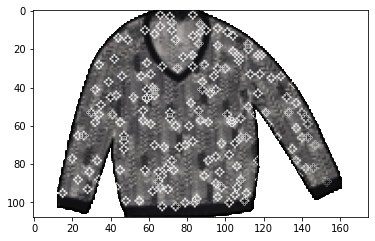

In [112]:
bg_classifier.draw_keypoints(index=31)

In [66]:
bg_classifier.predict(A_test, y_test)

100%|██████████| 558/558 [00:00<00:00, 1977.67it/s]


                 precision    recall  f1-score   support

       culottes       0.71      0.16      0.26        95
     doll dress       0.29      0.15      0.20        39
    drop sleeve       0.00      0.00      0.00        14
   gitana skirt       0.00      0.00      0.00         1
   kimono dress       0.50      0.14      0.22        14
  long cardigan       0.00      0.00      0.00         1
      long coat       1.00      0.08      0.15        12
     long dress       0.29      0.45      0.35        22
    long duster       0.00      0.00      0.00         3
    long sleeve       0.36      0.44      0.40       120
           maxi       0.00      0.00      0.00         3
medium cardigan       0.00      0.00      0.00         2
    medium coat       0.00      0.00      0.00        12
      miniskirt       0.00      0.00      0.00         5
      patterned       0.50      0.16      0.24        19
        printed       0.54      0.37      0.44        19
   sheath dress       0.00    

/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francescobazzani/miniconda3/envs/fml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

array(['culottes', 'solid colours', 'long sleeve', 'long sleeve',
       'solid colours', 'doll dress', 'long sleeve', 'solid colours',
       'solid colours', 'long sleeve', 'solid colours', 'doll dress',
       'long sleeve', 'solid colours', 'solid colours', 'solid colours',
       'long sleeve', 'long sleeve', 'long sleeve', 'solid colours',
       'solid colours', 'solid colours', 'solid colours', 'long sleeve',
       'solid colours', 'solid colours', 'printed', 'long sleeve',
       'solid colours', 'solid colours', 'long sleeve', 'long sleeve',
       'solid colours', 'solid colours', 'long dress', 'patterned',
       'long sleeve', 'solid colours', 'doll dress', 'solid colours',
       'solid colours', 'long sleeve', 'long sleeve', 'solid colours',
       'doll dress', 'solid colours', 'long sleeve', 'long sleeve',
       'solid colours', 'solid colours', 'solid colours', 'solid colours',
       'solid colours', 'solid colours', 'long sleeve', 'long sleeve',
       'long sleev

In [67]:
new_test_features = bg_classifier.transform_features(A_test)

100%|██████████| 558/558 [00:00<00:00, 1770.33it/s]


In [113]:
new_train_features = bg_classifier.features

In [114]:
from sklearn.cluster import KMeans
scaler = StandardScaler()

kmeans = KMeans(n_clusters=4, random_state=0).fit(new_train_features)

In [115]:
n_clusters = 4
clusters = {i:[] for i in range(n_clusters)}
for index, cluster in zip(range(len(kmeans.labels_)), kmeans.labels_):
    original_class = y_train[index]
    clusters[cluster].append(original_class)

counted = []
for cluster, list_items in clusters.items():
    count = Counter(list_items)
    tmp = []
    for class_, value in count.items():
        tmp.append(value)
    counted.append(tmp)

In [116]:
Counter(clusters[0]).items()

dict_items([('sleeveless', 158), ('long coat', 45), ('patterned', 66), ('long sleeve', 461), ('shirt dress', 11), ('doll dress', 64), ('short sleeves', 155), ('maxi', 16), ('drop sleeve', 48), ('kimono dress', 96), ('printed', 89), ('solid colours', 209), ('sheath dress', 23), ('culottes', 86), ('gitana skirt', 8), ('short cardigan', 8), ('medium coat', 34), ('long duster', 6), ('medium cardigan', 22), ('short coat', 35), ('trapeze dress', 30), ('long dress', 36), ('shorts', 8), ('long cardigan', 3), ('miniskirt', 7), ('capris', 6), ('tracksuit', 7)])

In [117]:
unique_labels = list(set(y_train))
new_map = {i:(0,0) for i in unique_labels}

for cluster in range(n_clusters):
    for class_, count in Counter(clusters[cluster]).items():
        if new_map[class_][0] < count:
            new_map[class_] = (count, cluster)

In [118]:
definitive_cluster = {i:[] for i in range(4)}
for key, tuple_ in new_map.items():
    _, map = tuple_
    definitive_cluster[map].append(key)
definitive_cluster

{0: ['maxi', 'short sleeves', 'kimono dress', 'printed'],
 1: ['long cardigan',
  'culottes',
  'long duster',
  'long dress',
  'short coat',
  'sheath dress',
  'long coat',
  'solid colours',
  'gitana skirt',
  'short cardigan',
  'trapeze dress',
  'sleeveless',
  'tracksuit',
  'miniskirt',
  'drop sleeve',
  'long sleeve',
  'medium coat',
  'medium cardigan',
  'doll dress',
  'capris'],
 2: ['shirt dress'],
 3: ['patterned', 'shorts']}